# 第10章 回帰分析 - 連続値を取る目的変数の予測

* https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch10/ch10.ipynb
* データセットの探索と可視化
* 線形回帰モデルを実装するための各種アプローチの考察
* 外れ値に対して頑健な回帰モデルのトレーニング
* 回帰モデルの評価と一般的な問題の診断
* 回帰モデルの非線形データでの学習

## 10.1 単純な線形回帰モデル

* 回帰直線: regression line
* オフセット: offcet
* 残差: residual
* 単回帰: simple linear regression
* 重回帰: multiple linear regression

In [18]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## 10.2 Housing データセットの探索

* https://archive.ics.uci.edu/ml/datasets/Housing
* 1978年に収集されたボストン近郊の住宅情報
* 506 個のサンプルの特徴量

1. CRIM: 犯罪発生率(人口単位)
2. ZN: 25,000平方フィート以上の住宅区画の割合
3. INDUS: 非小売業の土地面積の割合(人口単位)
4. CHAS: チャールズ川沿いかどうか(川沿いは1 ,そうでない場合は0)
5. NOX: 窒素酸化物の濃度(pphm単位)
6. RM: 1戸あたりの平均部屋数
7. AGE: 1940年よりも前に建てられた家屋の割合
8. DIS: ボストンの主な5つの雇用圏までの重み付きの距離
9. RAD: 幹線道路へのアクセス指数
10. TAX: 10,000ドルあたりの所得税率
11. PTRATIO: 教師あたりの生徒の数(人口単位)
12. B: 1000(Bk - 0.63)^2 として計算: Bkはアフリカ系アメリカ人居住者の割合(人口単位)
13. LSTAT: 低所得者の割合
14. MEDV: 住宅価格の中央値(単位 1,000ドル)

In [2]:
import pandas as pd

# データを読むこむ
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                 header=None,
                 sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### 10.2.1 データセットの重要な特性を可視化する

* 探索的データ解析(Exploratory Data Analysis: EDA)

```
$ pip install seaborn
```

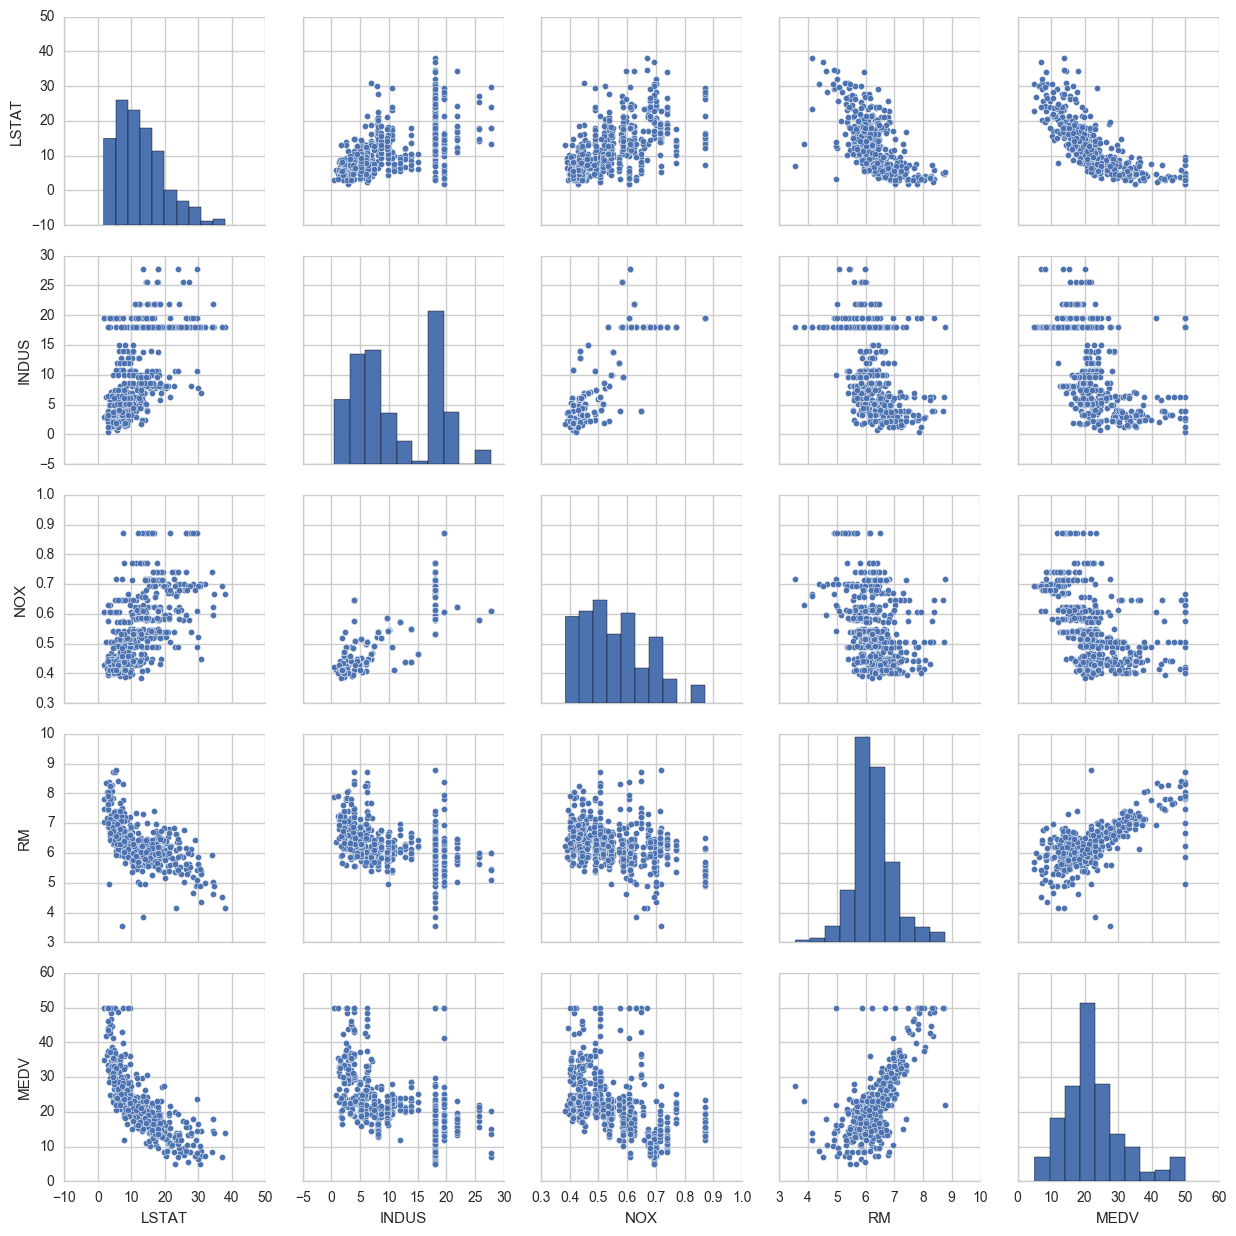

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# グラフのスタイルを指定
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
# 変数のペアの関係をプロット
sns.pairplot(df[cols], size=2.5)
plt.show()

* ピアソンの積率相関係数(Pearson product-moment correlation coefficient)
* ピアソンのr(Pearons's r)

[[ 1.          0.60379972  0.59087892 -0.61380827 -0.73766273]
 [ 0.60379972  1.          0.76365145 -0.39167585 -0.48372516]
 [ 0.59087892  0.76365145  1.         -0.30218819 -0.42732077]
 [-0.61380827 -0.39167585 -0.30218819  1.          0.69535995]
 [-0.73766273 -0.48372516 -0.42732077  0.69535995  1.        ]]


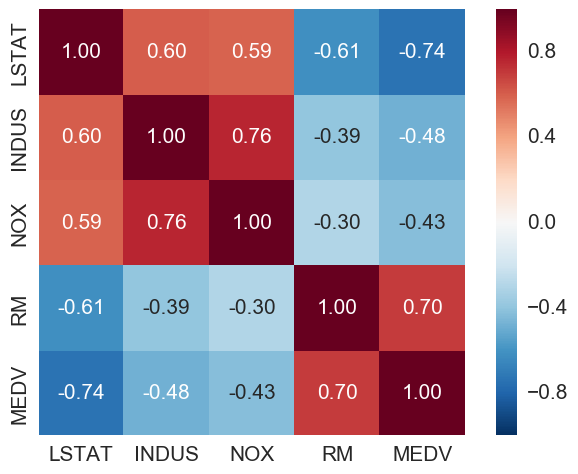

In [4]:
# 相関行列をヒートマップとしてプロットする
import numpy as np
cm = np.corrcoef(df[cols].values.T) # ピアソンの積率相関係数を計算
sns.set(font_scale=1.5)
print(cm)
hm = sns.heatmap(cm, # 第1引数の相関係数をもとにヒートマップを作成
                 cbar=True, # カラーバーの表示
                 annot=True, # データ値の表示
                 square=True, # 色矩形の正方形化
                 fmt='.2f', # 数値の表示形式
                 annot_kws={'size': 15}, # データ値のサイズの指定
                 yticklabels=cols, # 行のメモリのラベル名
                 xticklabels=cols) # 列のメモリのラベル名
plt.show()

## 10.3 最小二乗線形回帰モデルの実装

* 最小二乗法(Ordinary Least Squares: OLS)

### 10.3.1 勾配降下法を使って回帰パラメータの回帰を解く

* 勾配降下法(GD)
* 確率的勾配降下法(SGD)

In [5]:
# 基本的な線形回帰モデル: 第2章のAdalineGDクラスを参照
class LinearRegressionGD(object):

    # 初期化を実行
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta # 学習率
        self.n_iter = n_iter # トレーニング回数
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    # 総入力を計算
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    # 予測値を計算
    def predict(self, X):
        return self.net_input(X)

In [6]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

/Users/takanori/Private/python-machine-learning/venv/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/takanori/Private/python-machine-learning/venv/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


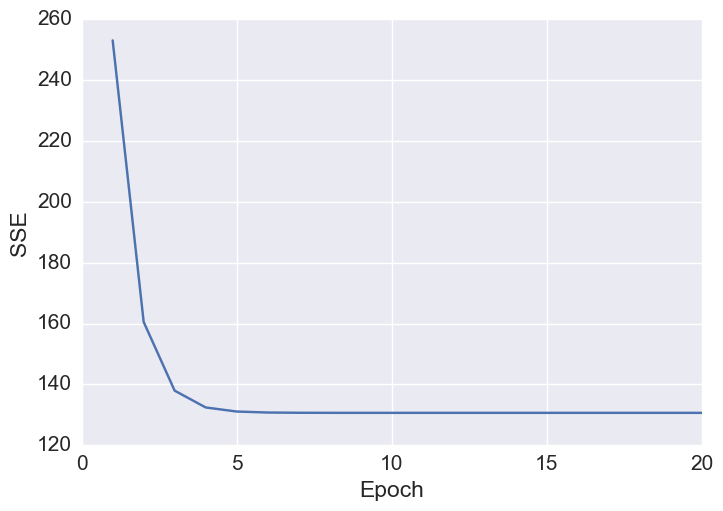

In [7]:
# エポック数とコストの関係を表す折れ線グラフ
from matplotlib import pyplot as plt
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [8]:
# トレーニングサンプルの散布図をプロットし、回帰直線を追加する変ルパー関数を定義
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

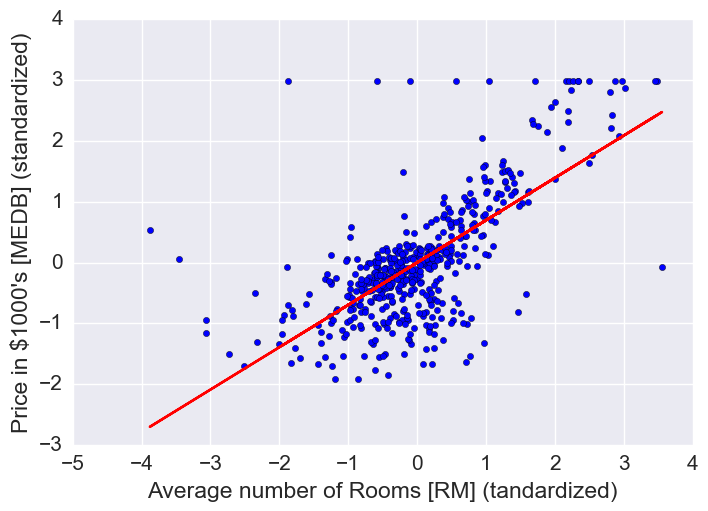

In [9]:
# 住宅価格に対する部屋数をプロット
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of Rooms [RM] (tandardized)')
plt.ylabel('Price in $1000\'s [MEDB] (standardized)')
plt.show()

In [10]:
num_rooms_std = sc_x.transform([5.0])
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


/Users/takanori/Private/python-machine-learning/venv/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [11]:
print('Slope: {:.3f}'.format(lr.w_[1]))
print('Intercept: {:.3f}'.format(lr.w_[0]))

Slope: 0.695
Intercept: -0.000


### 10.3.2 scikit-learnを使って回帰モデルの係数を推定する

In [13]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print(slr.coef_[0])
print(slr.intercept_)

9.10210898118
-34.6706207764


/Users/takanori/Private/python-machine-learning/venv/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


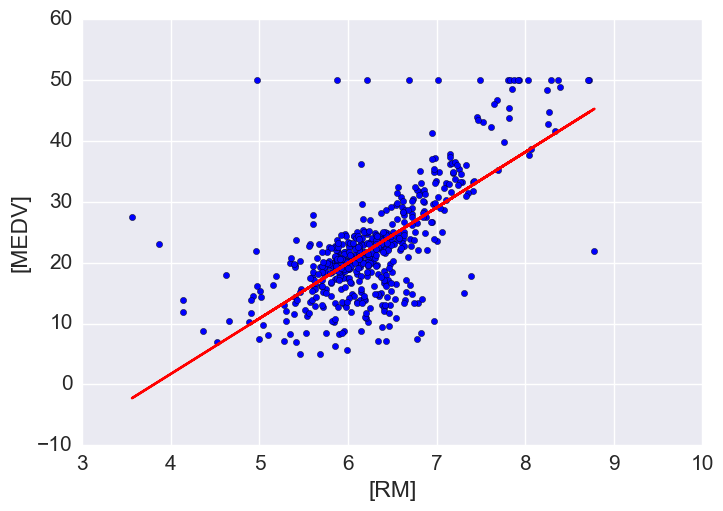

In [15]:
lin_regplot(X, y, slr)
plt.xlabel('[RM]')
plt.ylabel('[MEDV]')
plt.show()

## 10.4 RANSACを使ったロバスト回帰モデルの学習

RANSAC(Random Sample Concensus)

1. 正常値としてランダムな数のサンプルを選択肢、モデル学習させる
2. 学習済のモデルに対して、その他すべてのデータ点を評価し、ユーザー指定の許容範囲となるデータ点を正常値に追加する
3. すべての正常値を使ってモデルを再び学習させる
4. 正常値に対する学習済のモデルの誤差を推定する
5. モデルの性能がユーザー指定のしきい値の条件を満たしている場合、またはイテレーションが規定の回数に達した場合はアルゴリズムを終了する。そうでなれけば、ステップ1に戻る


In [19]:
from sklearn.linear_model import RANSACRegressor

if Version(sklearn_version) < '0.18':
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
                             residual_threshold=5.0, 
                             random_state=0)
else:
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             loss='absolute_loss', 
                             residual_threshold=5.0, 
                             random_state=0)

ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

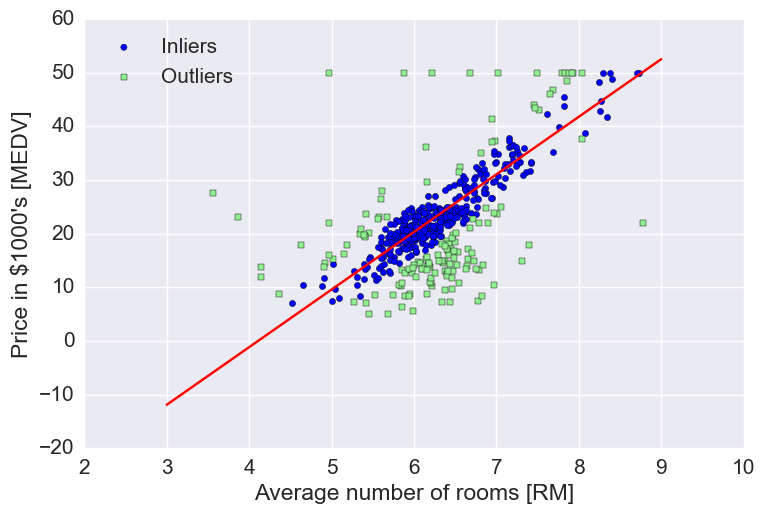

In [20]:
# 正常値を表す真偽値を取得
inlier_mask = ransac.inlier_mask_
# 異常値を表す真偽値を取得
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
# 正常値をプロット
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
# 異常値をプロット
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
# 予測値をプロット
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
# 傾き
print(ransac.estimator_.coef_[0])
# 切片
print(ransac.estimator_.intercept_)

10.7345088085
-44.0890642864


## 10.5 線形回帰モデルの性能評価

In [22]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

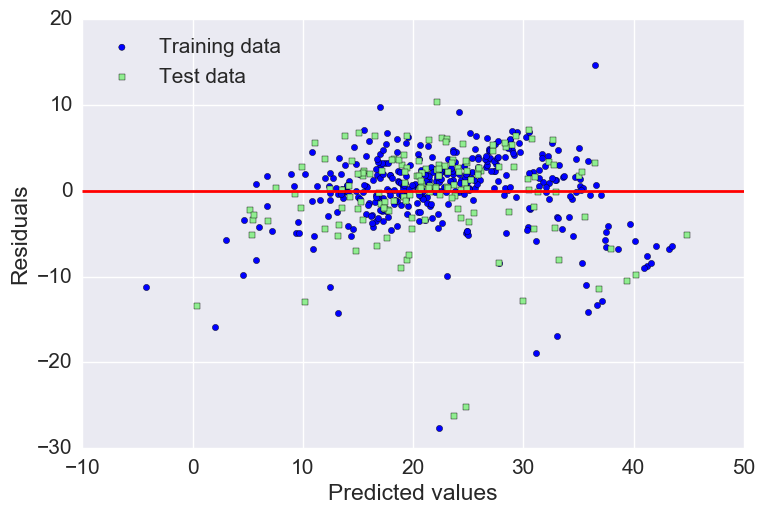

In [23]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

* 平均二乗誤差(Mean Squared Error: MSE)

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 平均二乗偏差
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
# 決定係数(R^2)のスコアを出力
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


## 10.6 回帰に生息化手法を使用する

* リッジ回帰(Ridge regression)
* LASSO(Least Absolute Shrinkage and Selection Operator)
* Elastic Net

## 10.7 多項式回帰: 線形回帰モデルから曲線を見出す

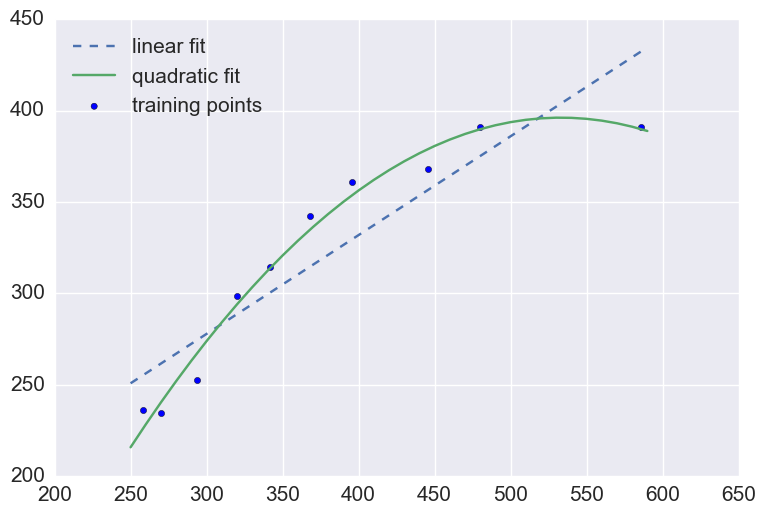

In [27]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)



# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/poly_example.png', dpi=300)
plt.show()



In [28]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


### 10.7.1 Housingデータセットで非線形関係をモデリングする

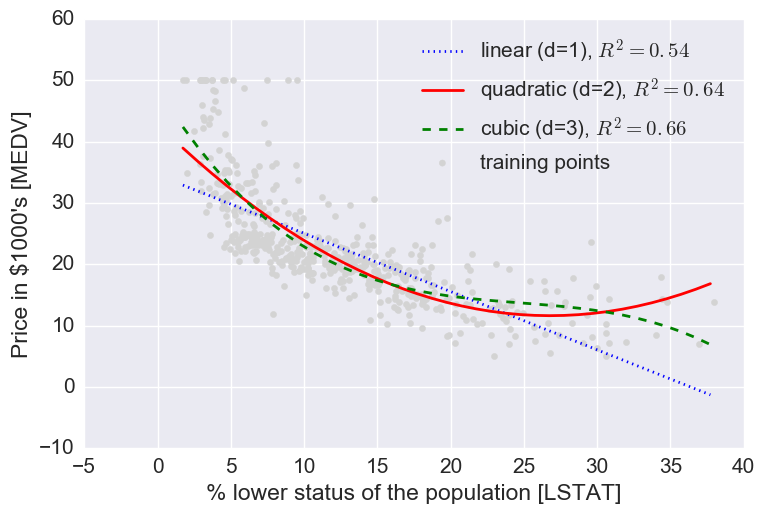

In [29]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

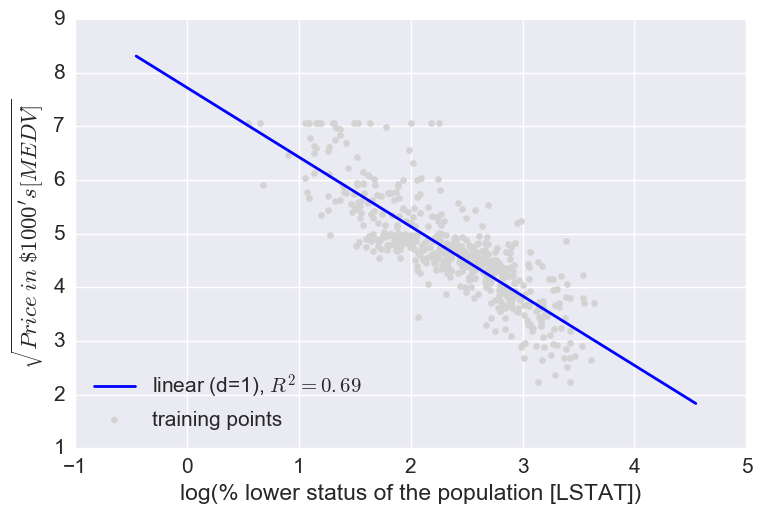

In [30]:


X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

### 10.7.2 ランダムフォレストを使って非線形関係に対処する

決定木回帰

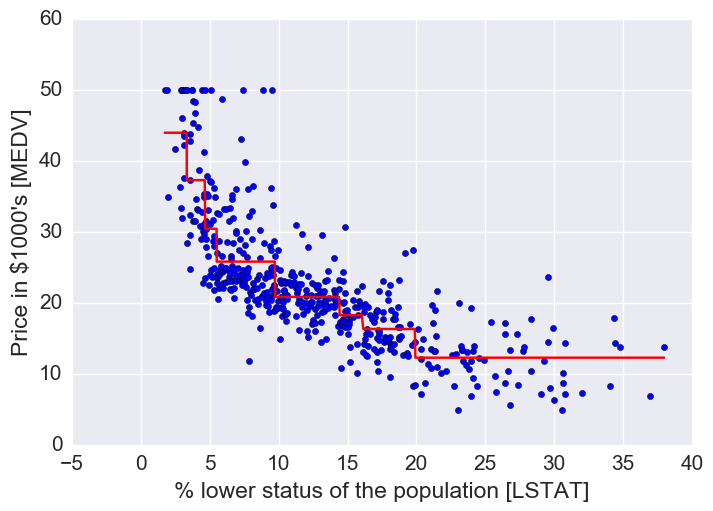

In [31]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

ランダムフォレスト回帰